# <h1><center>Relax Challenge</center></h1>

## <center>Hio Wa Mak</center>

## Import packages

In [1]:
#Import pandas, matplotlib.pyplot, and seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
#check current directory
#os.getcwd()

## Read in the data

In [3]:
# Read in engagement data from a csv file
df_engagement = pd.read_csv('takehome_user_engagement.csv', encoding='latin-1')
df_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
# Read in users data from a csv file
df_users = pd.read_csv('takehome_users.csv', encoding='latin-1')
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


## Codebook

**name:** the user's name <br>
**object_id:** the user's id <br>
**email:** email address <br>
**creation_source:** how their account was created. This takes on one of 5 values: <br>
1. **PERSONAL_PROJECTS:** invited to join another user's
personal workspace <br>
2. **GUEST_INVITE:** invited to an organization as a guest
(limited permissions) <br>
3. **ORG_INVITE:** invited to an organization (as a full member) <br>
4. **SIGNUP:** signed up via the website <br>
5. **SIGNUP_GOOGLE_AUTH:** signed up using Google Authentication (using a Google email account for their login id) <br>
**creation_time:** when they created their account <br>
**last_session_creation_time:** unix timestamp of last login <br>
**opted_in_to_mailing_list:** whether they have opted into receiving marketing emails <br>
**enabled_for_marketing_drip:** whether they are on the regular
marketing email drip <br>
**org_id:** the organization (group of users) they belong to <br>
**invited_by_user_id:** which user invited them to join (if applicable).

## Examine details about the datasets

In [5]:
#Examine info on this dataset
df_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [6]:
#Examine info on this dataset
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


There is no missing data in the engagement dataset, but there is some missing data on the `last_session_creation_time` and `invited_by_user_id` variables in the users dataset. The time stamp variables should be converted to datetime object.

## Clean the data

In [7]:
# Convert date time object:
df_engagement['time_stamp'] = pd.to_datetime(df_engagement['time_stamp'])
df_users['creation_time'] = pd.to_datetime(df_users['creation_time'])
df_users['last_session_creation_time'] = pd.to_datetime(df_users['last_session_creation_time'], unit='s')

## Define adopted users

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven-day period

In [8]:
# Remove Time Component (Set Time to 00:00:00)
df_engagement["login_date"] = df_engagement["time_stamp"].dt.floor("D")

# Remove duplicate logins on the same day per user
df_engagement_grouped = df_engagement.drop_duplicates(subset=["user_id", "login_date"])

# Sort by user and login date
df_engagement_grouped = df_engagement_grouped.sort_values(by=["user_id", "login_date"])

#Print the max login date
print(max(df_engagement_grouped["login_date"]))

# Set login_date as Index
df_engagement_grouped = df_engagement_grouped.set_index("login_date")

# Assigning rolling count
df_engagement_grouped["rolling_count"] = (
    df_engagement_grouped.groupby("user_id", group_keys=False)["user_id"]  # Explicitly select "user_id"
    .apply(lambda x: x.rolling("7D").count())
)

# Display the grouped data
df_engagement_grouped.head(20)


2014-06-06 00:00:00


,time_stamp,user_id,visited,rolling_count
login_date,,,,
2014-04-22,2014-04-22 03:53:30,1,1,1.0
2013-11-15,2013-11-15 03:45:04,2,1,1.0
2013-11-29,2013-11-29 03:45:04,2,1,1.0
2013-12-09,2013-12-09 03:45:04,2,1,1.0
2013-12-25,2013-12-25 03:45:04,2,1,1.0
2013-12-31,2013-12-31 03:45:04,2,1,2.0
2014-01-08,2014-01-08 03:45:04,2,1,1.0
2014-02-03,2014-02-03 03:45:04,2,1,1.0
2014-02-08,2014-02-08 03:45:04,2,1,2.0


In [9]:
# Identify and extract unique user IDs of adopted users
adopted_users = df_engagement_grouped[df_engagement_grouped["rolling_count"] >= 3]["user_id"].unique()

# Convert to a Python list if needed
adopted_users_list = adopted_users.tolist()

# Count the list
len(adopted_users_list)


1602

#### Create an `adopted` variable in the users dataframe

In [10]:
# Ensure adopted_users_list is a Python list
adopted_users_list = set(adopted_users_list)  # Convert to a set for faster lookup

# Add "adopted" column: 1 if user is in adopted_users_list, else 0
df_users["adopted"] = df_users["object_id"].isin(adopted_users_list).astype(int)

df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0


In [11]:
# Check to confirm the number matches
df_users['adopted'].sum()

1602

There are 1602 adopted users out of 12000 users. Therefore, the adoption rate is 13.35%.

## Identify factors that predict future user adoption

In [12]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
 10  adopted                     12000 non-null  int32         
dtypes: datetime64[ns](2), float64(1), int32(1), int64(4), 

### Further Cleaning and Feature Engineering

In [13]:
df_users2 = df_users.copy()

# For datetime objects, less drop the hours, minutes, and seconds
df_users2["creation_time"] = df_users2["creation_time"].dt.floor("D")
df_users2["last_session_creation_time"] = df_users["last_session_creation_time"].dt.floor("D")

# The latest date in the engagement dataset is 2014-06-06
# Create recency measures
max_date = pd.to_datetime("2014-06-06")  # Reference date

# Calculate recency as the number of days since creation_time
df_users2["creation_recency"] = (max_date - df_users2["creation_time"]).dt.days
# Calculate recency as the number of days since last login
df_users2["login_recency"] = (max_date - df_users2["last_session_creation_time"]).dt.days

# One-hot encoding for creation source
df_users2 = pd.get_dummies(df_users2, columns=["creation_source"], prefix="cs")

# Frequency of org_id
print('number of org_id:', df_users2["org_id"].nunique())

# Create the new variable invited_by_user
df_users2['invited_by_user'] = df_users2['invited_by_user_id'].notna().astype(int)

df_users2.head(10)

number of org_id: 417


,object_id,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,creation_recency,login_recency,cs_GUEST_INVITE,cs_ORG_INVITE,cs_PERSONAL_PROJECTS,cs_SIGNUP,cs_SIGNUP_GOOGLE_AUTH,invited_by_user
0,1,2014-04-22,Clausen August,AugustCClausen@yahoo.com,2014-04-22,1,0,11,10803.0,0,45,45.0,True,False,False,False,False,1
1,2,2013-11-15,Poole Matthew,MatthewPoole@gustr.com,2014-03-31,0,0,1,316.0,1,203,67.0,False,True,False,False,False,1
2,3,2013-03-19,Bottrill Mitchell,MitchellBottrill@gustr.com,2013-03-19,0,0,94,1525.0,0,444,444.0,False,True,False,False,False,1
3,4,2013-05-21,Clausen Nicklas,NicklasSClausen@yahoo.com,2013-05-22,0,0,1,5151.0,0,381,380.0,True,False,False,False,False,1
4,5,2013-01-17,Raw Grace,GraceRaw@yahoo.com,2013-01-22,0,0,193,5240.0,0,505,500.0,True,False,False,False,False,1
5,6,2013-12-17,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,2013-12-19,0,0,197,11241.0,0,171,169.0,True,False,False,False,False,1
6,7,2012-12-16,Sewell Tyler,TylerSewell@jourrapide.com,2012-12-20,0,1,37,NaN,0,537,533.0,False,False,False,True,False,0
7,8,2013-07-31,Hamilton Danielle,DanielleHamilton@yahoo.com,NaT,1,1,74,NaN,0,310,NaN,False,False,True,False,False,0
8,9,2013-11-05,Amsel Paul,PaulAmsel@hotmail.com,NaT,0,0,302,NaN,0,213,NaN,False,False,True,False,False,0
9,10,2013-01-16,Santos Carla,CarlaFerreiraSantos@gustr.com,2014-06-03,1,1,318,4143.0,1,506,3.0,False,True,False,False,False,1


In [14]:
df_users2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   last_session_creation_time  8823 non-null   datetime64[ns]
 5   opted_in_to_mailing_list    12000 non-null  int64         
 6   enabled_for_marketing_drip  12000 non-null  int64         
 7   org_id                      12000 non-null  int64         
 8   invited_by_user_id          6417 non-null   float64       
 9   adopted                     12000 non-null  int32         
 10  creation_recency            12000 non-null  int64         
 11  login_recency               8823 non-null   float64   

### Exploratory data analysis

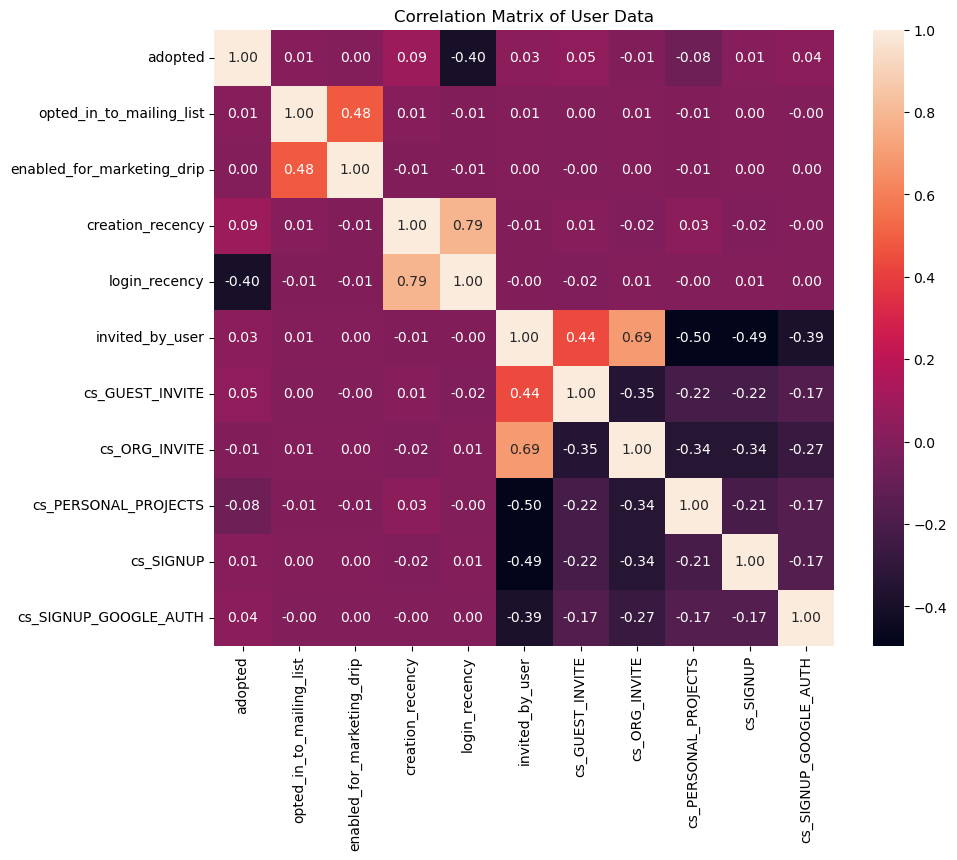

In [15]:
cor_columns = ["adopted", "opted_in_to_mailing_list", "enabled_for_marketing_drip", "creation_recency", "login_recency", "invited_by_user", "cs_GUEST_INVITE", "cs_ORG_INVITE", "cs_PERSONAL_PROJECTS", "cs_SIGNUP", "cs_SIGNUP_GOOGLE_AUTH"]

df_users_cor = df_users2[cor_columns]

# Make a heat map for selected variables
plt.figure(figsize=(10, 8))
sns.heatmap(df_users_cor.corr(), annot=True, fmt=".2f")
plt.title('Correlation Matrix of User Data')
plt.show()


Based on correlations, the time since last login `login_recency` is highly correlated with adoption. Specifically, the more days since the last login was associated with lower adoption. Also, the time since creation `creation_recency` is somewhat correlated with adoption such that users that had created their account longer are more likely to be adopted users. Lastly, users who created their account because they were invited to join another user's personal workspace `cs_PERSONAL_PROJECTS` are less likely to be adopted users. Other variables do not seem to be much correlated with adoption.

In [16]:
# Convert boolean columns to interger for analysis
bool_cols = ["cs_GUEST_INVITE", "cs_ORG_INVITE", "cs_PERSONAL_PROJECTS", "cs_SIGNUP", "cs_SIGNUP_GOOGLE_AUTH"]  # List of Boolean columns
df_users2[bool_cols] = df_users2[bool_cols].astype(int)

df_users2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   last_session_creation_time  8823 non-null   datetime64[ns]
 5   opted_in_to_mailing_list    12000 non-null  int64         
 6   enabled_for_marketing_drip  12000 non-null  int64         
 7   org_id                      12000 non-null  int64         
 8   invited_by_user_id          6417 non-null   float64       
 9   adopted                     12000 non-null  int32         
 10  creation_recency            12000 non-null  int64         
 11  login_recency               8823 non-null   float64   

### Predictive modeling

In [17]:
import time
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Select features (X) and target variable (y)
X = df_users2[["opted_in_to_mailing_list", "enabled_for_marketing_drip", "creation_recency", "login_recency", "invited_by_user", "cs_GUEST_INVITE", "cs_ORG_INVITE", "cs_PERSONAL_PROJECTS", "cs_SIGNUP", "cs_SIGNUP_GOOGLE_AUTH"]]
y = df_users2["adopted"]

# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=30, stratify=y)

In [18]:
# Fit a random forest model

# Define parameters for randomized search

param_dist = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'class_weight': [None, 'balanced']
    #'min_samples_split': [2, 5, 10],
    #'min_samples_leaf': [1, 2, 4],
}

# Set up the random forest model
rf = RandomForestClassifier(random_state=42)

# Setup the RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator=rf,
                               param_distributions=param_dist,
                               n_iter=20,  
                               cv=5, 
                               scoring="recall",
                               verbose=2,
                               random_state=42,
                               n_jobs=-1)  

# Time the fitting process
start_time = time.time()
rf_random.fit(X_train, y_train)
end_time = time.time()
est_time = (end_time - start_time)

# Print estimation time
print(f"Estimation time: {est_time/60:.2f} minutes")

# Print the best parameters
print("Best hyperparameters found:", rf_random.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Estimation time: 0.43 minutes
Best hyperparameters found: {'n_estimators': 100, 'max_features': None, 'max_depth': 10, 'criterion': 'gini', 'class_weight': 'balanced'}


In [19]:
# Obtain evaluation metrics for training data:
# Step 1: Use cross_val_predict to get cross-validated predictions for training data
y_train_pred = cross_val_predict(rf_random.best_estimator_, X_train, y_train, cv=5)

# Step 2: Calculate the confusion matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)

# Step 3: Generate the classification report
rf_class_report = classification_report(y_train, y_train_pred)

# Print results
print("Confusion Matrix:")
print(conf_matrix)

print("\nRandom Forest Classification Report:")
print(rf_class_report)

Confusion Matrix:
[[7665  134]
 [ 127 1074]]

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      7799
           1       0.89      0.89      0.89      1201

    accuracy                           0.97      9000
   macro avg       0.94      0.94      0.94      9000
weighted avg       0.97      0.97      0.97      9000



In [20]:
# Examine feature coefficient from the best model
importances = rf_random.best_estimator_.feature_importances_  # Get feature importances

# Create a DataFrame to display the feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the top 5 most important features
print(feature_importance_df.head(5))

                      Feature  Importance
3               login_recency    0.723129
2            creation_recency    0.261772
9       cs_SIGNUP_GOOGLE_AUTH    0.002743
1  enabled_for_marketing_drip    0.002450
7        cs_PERSONAL_PROJECTS    0.001807


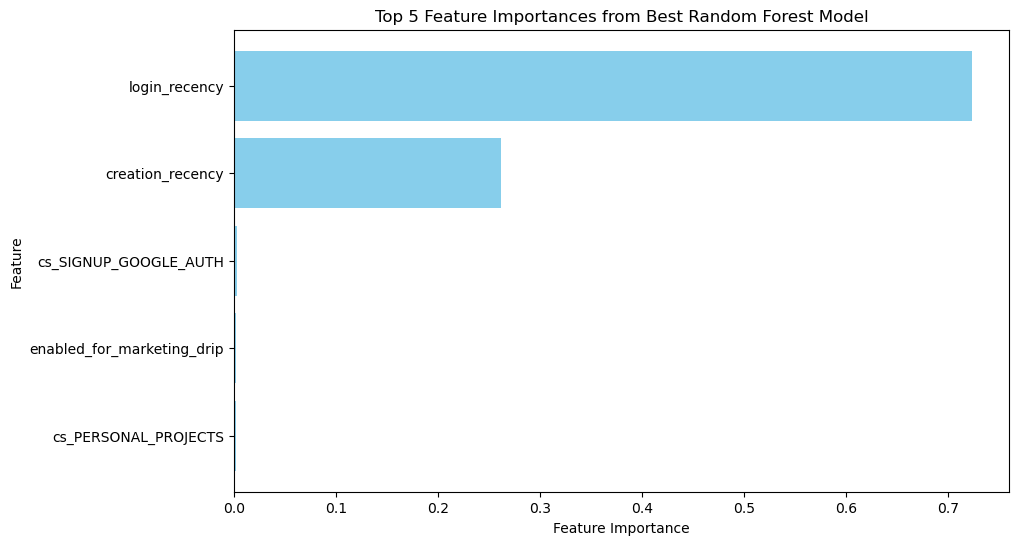

In [21]:
# Select the top 5 most important features
top_5_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(5)

# Plot the top 5 feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_5_features['Feature'], top_5_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 5 Feature Importances from Best Random Forest Model')
plt.gca().invert_yaxis()  # Invert y-axis to show most important at the top
plt.show()

For predictive modeling, given the imbalanced data (low rate of adopted users compared to non-adopted users), a random forest classifier was used. Also, recall was chosen as the primary scoring criterion for cross-validation and final model selection to prioritize sensitivity. Further, class weights were added as a hyperparameter to help the model better account for the imbalance. 

Results from random forests are largely consistent with those derived from correlations, except that `cs_PERSONAL_PROJECTS` does not appear to be an important predictor of adoption.

### Model Evaluation Using Testing Data

In [22]:
# Evaluate on the test set
y_pred = rf_random.predict(X_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Generate the classification report
test_class_report = classification_report(y_test, y_pred)

print("\nRandom Forest Classification Report:")
print(test_class_report)


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2599
           1       0.89      0.91      0.90       401

    accuracy                           0.97      3000
   macro avg       0.94      0.95      0.94      3000
weighted avg       0.97      0.97      0.97      3000



## Summary and Conclusion

This analysis defines adopted users as those who have logged in on at least three separate days within a seven-day period, based on engagement data. Approximately 13% of all users meet this criterion.

Before examining factors that influence user adoption, a few variables were created as new features, including two recency measures (i.e., `login_recency` and `creation_recency`). When predicting user adoption, results suggest that `login_recency` (more recent last login) and `creation_recency` (older account age) are strong predictors of higher adoption rates. These results are consistent across correlations and a random forest classification model.

The random forest classifier demonstrated excellent performance, achieving a macro-average recall, F1-score, and precision of 0.94, along with an accuracy of 0.97. Feature importance analysis identified `login_recency` and `creation_recency` as the most influential predictors.

When tested on unseen data, the model's accuracy, precision, recall, and F1-score remained consistent with training results, confirming strong generalization and robustness.